<a href="https://colab.research.google.com/github/Bicchie/Skin-Lesions-Classification/blob/main/1_Data_Preprocessing_and_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing and EDA

These are the steps of the Data Preprocessing and EDA phase:

0.   Load Dataset
1.   **E**xploratory **D**ata **A**nalisys
2.   Split Dataset
3.   Undersampling and Data Augmentation



## Import Libraries and Constants

In [ ]:
from google.colab import drive
import os
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
import tensorflow as tf
import random
from random import randint
import numpy as np
import shutil

In [ ]:
CLASSES = ['Actinic', 'BCC', 'Dermatofibroma', 'Keratosis', 'Melanoma', 'Nevu', 'Vascular']
DATA_DIR = '/content/gdrive/MyDrive/SkinCancer/skin-cancer-isic-dataset-2018/Fold_1'
DRIVE_ORIGINAL_DS_DIR = '/content/gdrive/MyDrive/SkinCancer/OriginalDataset'
DRIVE_BALANCED_DS_DIR = '/content/gdrive/MyDrive/SkinCancer/BalancedDataset'

LOCAL_ORIGINAL_DS_DIR = '/content/OriginalDataset'
LOCAL_BALANCED_DS_DIR = '/content/BalancedDataset'

Connection to Google Drive

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## 0. Load Dataset

Download the dataset from Kaggle

In [ ]:
! pip install -q kaggle

! mkdir -p ~/.kaggle
! cp "/content/gdrive/MyDrive/SkinCancer/kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d vardhilpatel/skin-cancer-isic-dataset-2018
! unzip -q skin-cancer-isic-dataset-2018.zip -d skin-cancer-isic-dataset-2018
! mv skin-cancer-isic-dataset-2018 /content/gdrive/MyDrive/SkinCancer/
! rm skin-cancer-isic-dataset-2018.zip

100% 1.84G/1.84G [00:07<00:00, 270MB/s]
100% 1.84G/1.84G [00:07<00:00, 253MB/s]


Since the International Skin Imaging Collaboration (ISIC) doesn't provide the Test set but only the Training and Validation, It's worth to merge the two sets and then divide the result in Training, Validation and Test set.

In [ ]:
for label in CLASSES:
  #path
  training_path = DATA_DIR + '/Training/Lesions/' + label
  val_path = DATA_DIR + '/Validation/Lesions/' + label
  new_path = DATA_DIR + '/' + label

  os.mkdir(new_path)
  #files
  training_files = os.listdir(training_path)
  val_files = os.listdir(val_path)
  
  print(label)
  print("Images in train directory: " + str(len(training_files)))
  print("Images in test directory: "+ str(len(val_files)))

  #moving files in the new directory
  for f in training_files:
    os.rename(training_path + '/' + f, new_path + '/' + f)
  for f in val_files:
    os.rename(val_path + '/' + f, new_path + '/' + f)

  os.rmdir(training_path)
  os.rmdir(val_path)

  print("Tot " + label + " Images: "+ str(len(os.listdir(new_path))))
  
shutil.rmtree(DATA_DIR + '/Validation')
shutil.rmtree(DATA_DIR + '/Training')

Actinic
Images in train directory: 262
Images in test directory: 65
Tot Actinic Images: 327
BCC
Images in train directory: 421
Images in test directory: 103
Tot BCC Images: 524
Dermatofibroma
Images in train directory: 92
Images in test directory: 23
Tot Dermatofibroma Images: 115
Keratosis
Images in train directory: 879
Images in test directory: 220
Tot Keratosis Images: 1099
Melanoma
Images in train directory: 891
Images in test directory: 222
Tot Melanoma Images: 1113
Nevu
Images in train directory: 5364
Images in test directory: 1341
Tot Nevu Images: 6705
Vascular
Images in train directory: 113
Images in test directory: 29
Tot Vascular Images: 142


In [ ]:
shutil.rmtree(DATA_DIR + '/Validation')
shutil.rmtree(DATA_DIR + '/Training')

## 1. Exploratory Data Analysis

All the images have the same size: 450x600 pixels.

Text(0.5, 1.0, '(450, 600, 3)')

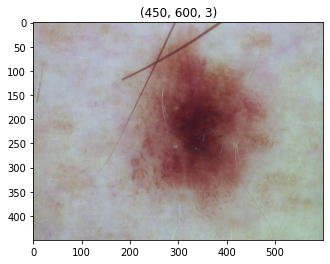

In [ ]:
path = '/content/gdrive/MyDrive/SkinCancer/skin-cancer-isic-dataset-2018/Fold_1/Nevus/ISIC_0024306.jpg'
img = mpimg.imread(path)
plt.imshow(img.astype("uint8"))
plt.title(str(img.shape))

Let's see some images for each classes.

In [ ]:
def show_samples(num_samples, base_dir):
  plt.figure(figsize=(10, 20))
  i = 0
  for label in CLASSES:
    path = base_dir + '/' + label
    for img_name in os.listdir(path):
      #img = cv2.imread(path + "/" + img_name)
      img=mpimg.imread(path + "/" + img_name)
      ax = plt.subplot(8, num_samples, i + 1)
      plt.imshow(img.astype("uint8"))
      plt.title(label)
      plt.axis("off")
      i += 1
      if i % num_samples == 0:
        break

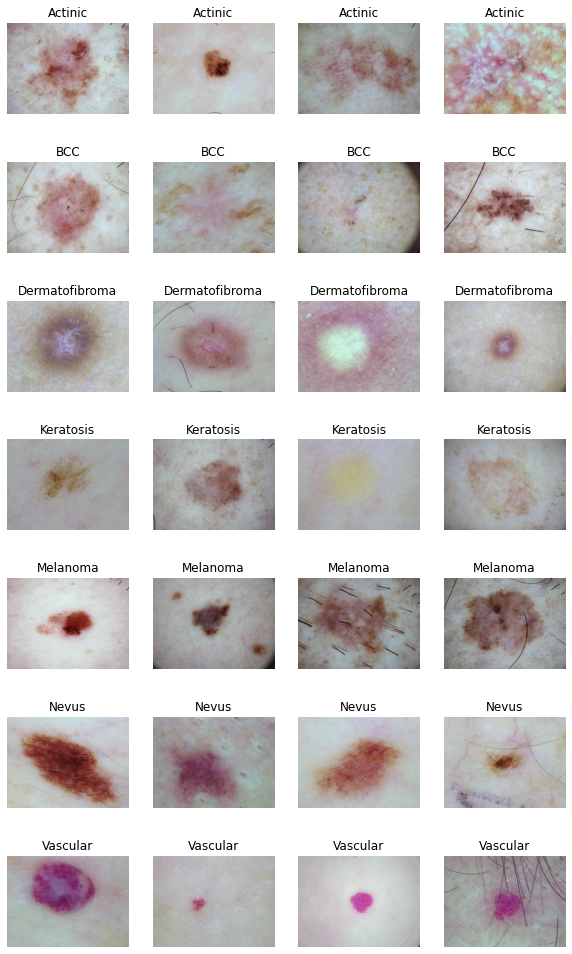

In [ ]:
show_samples(4, DATA_DIR)

And now the composition of the Dataset.

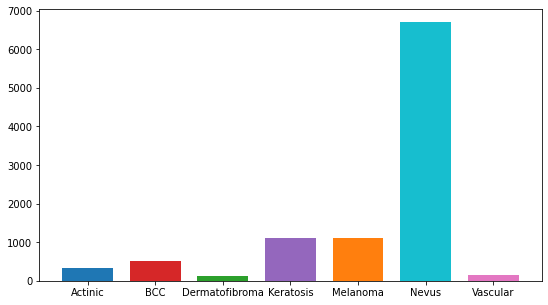

In [ ]:
num_per_classes = {}
for label in CLASSES:
  path = DATA_DIR + '/' + label
  num_per_classes[label] = len(os.listdir(path))

keys = list(num_per_classes.keys())  
values = list(num_per_classes.values())

plt.figure(figsize=(9,5))
plt.bar(range(len(CLASSES)), values, tick_label=keys, width=0.75, color=['tab:blue', 'tab:red', 'tab:green', 'tab:purple', 'tab:orange', 'tab:cyan', 'tab:pink', 'tab:brown'])

plt.show()

As we can see the dataset is clearly unbalanced. Nevus class accounts for almost 67% of the entire dataset while Vascular and Dermatofibroma for more or less 1%. This problem will be addressed later on.

It is provided also metadata related to each image, let's look at this data since it could be exploited with a Multimodal Fusion approach.

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/SkinCancer/HAM10000_metadata.csv', delimiter=',')
df.dataframeName = 'HAM10000_metadata.csv'
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')
df.head(5)

There are 10015 rows and 7 columns


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Text(0.5, 1.0, 'Gender of Patient')

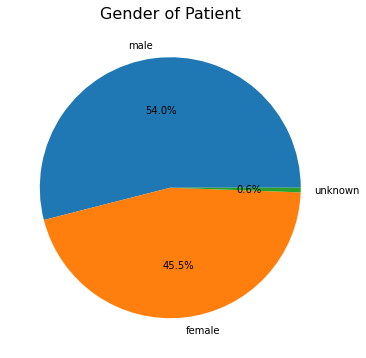

In [ ]:
bar, ax = plt.subplots(figsize = (6,6))
plt.pie(df['sex'].value_counts(), labels = df['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)

Text(0.5, 1.0, 'Histogram of Age of Patients')

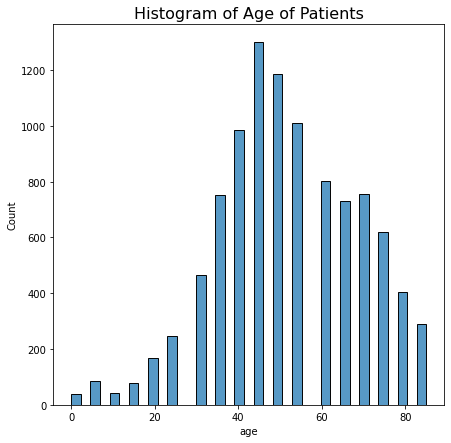

In [ ]:
bar, ax = plt.subplots(figsize=(7,7))
sns.histplot(df['age'])
plt.title('Histogram of Age of Patients', size=16)

Text(0.5, 1.0, 'Histogram of Age of Patients')

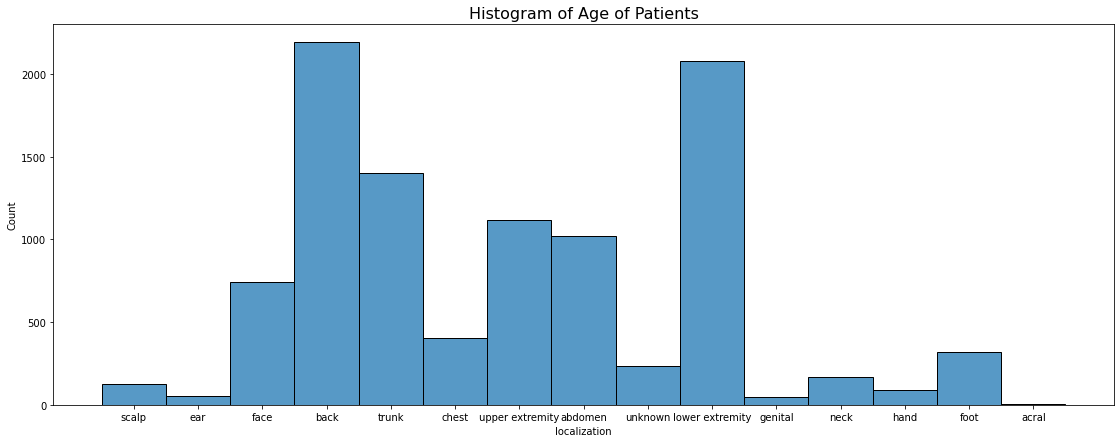

In [ ]:
bar, ax = plt.subplots(figsize=(19,7))
sns.histplot(df['localization'])
plt.title('Histogram of Age of Patients', size=16)

In [ ]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [ ]:
# convert categorical into one hot encoding
df = pd.get_dummies(df, columns = ['localization'], prefix = [''])
df = pd.get_dummies(df, columns = ['sex'], prefix = [''])

In [ ]:
del df['lesion_id'], df['dx_type'], df['_unknown']

In [ ]:
df['age'] = np.ceil(df['age']/10)

In [ ]:
dictionary = {0:'a', 1:'b', 2:'c', 3:'d', 4:'e', 5:'f', 6:'g', 7:'h', 8:'i', 9:'l'}
df = df.replace({"age": dictionary})
df = pd.get_dummies(df, columns = ['age'], prefix = [''])

In [ ]:
df.shape

(10015, 28)

In [ ]:
df

,image_id,dx,_abdomen,_acral,_back,_chest,_ear,_face,_foot,_genital,...,_a,_b,_c,_d,_e,_f,_g,_h,_i,_l
0,ISIC_0027419,bkl,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,ISIC_0025030,bkl,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,ISIC_0026769,bkl,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,ISIC_0025661,bkl,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,ISIC_0031633,bkl,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,ISIC_0033084,akiec,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
10011,ISIC_0033550,akiec,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
10012,ISIC_0033536,akiec,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
10013,ISIC_0032854,akiec,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


## 2. Split Dataset

I create 2 identical dataset:


*   *Original Dataset*: is the exact dataset given by the ISIC, It will be used with the class weights technique.
*   *Balanced Dataset*: there will be oversampling and undersampling operations in order to balance the dataset.

Both approach will be used to approach the **CLASSES UNBALANCING** problem in order to be compared.



In [ ]:
!pip install split-folders tqdm
import splitfolders

splitfolders.ratio(DATA_DIR, output=DRIVE_BALANCED_DS_DIR, seed=123, ratio=(0.7, 0.15, 0.15), group_prefix=None)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 10025 files [05:42, 29.23 files/s]


In [ ]:
splitfolders.ratio(DATA_DIR, output=DRIVE_ORIGINAL_DS_DIR, seed=123, ratio=(0.7, 0.15, 0.15), group_prefix=None)

Copying files: 10025 files [02:28, 67.63 files/s]


## 3. Undersampling and Data Augmentation

I decided to set 300 as a fair number of samples per class.

In [ ]:
NUM_SAMPLES = 300

In [ ]:
def random_flip_or_rotation(original_image):
  '''
  random_flip_or_rotation randomly rotates or flips the image
  :param original_image: the image on which to perform the transformation
  :return: the transformed image
  '''
  if random.randint(0,1): # decide whether to flip the image or not
    horizontal = random.randint(0,1)
    if horizontal:
      new_image = tf.image.flip_left_right(original_image)
    else:
      new_image = tf.image.flip_up_down(original_image)
  else: # rotate the image of 180°)
    new_image = tf.image.rot90(original_image, 2)

  return np.asarray(new_image)

Make the dataset balanced.

In [ ]:
for i in range(0,7):
  path = DRIVE_BALANCED_DS_DIR + "/train/" + str(CLASSES[i])
  files = os.listdir(path)
  print(len(files))

300
300
300
300
300
300
300


I have to make the oversample and undersample operations only on the Training Set.

In [ ]:
for i in range(0,7):
  path = DRIVE_BALANCED_DS_DIR + "/train/" + str(CLASSES[i])
  files = os.listdir(path)
  if len(files) < NUM_SAMPLES:
    j = 0
    #oversample: taking random image and rotate it
    while True:
      img = cv2.imread(path + "/" + files[randint(0,len(files))-1])
      aug_img = random_flip_or_rotation(img)
      filename = path + "/" + str(j) + ".jpg"
      cv2.imwrite(filename, aug_img)
      files = os.listdir(path)
      j = j + 1
      if len(files) == NUM_SAMPLES:
        break
  elif len(files) > NUM_SAMPLES:
    # undersample: deleting images
    to_del = len(files)-NUM_SAMPLES
    for i in range(0,to_del):
      os.remove(path + "/" + files[i])

In [ ]:
for i in range(0,7):
  path = DRIVE_BALANCED_DS_DIR + "/train/" + str(CLASSES[i])
  files = os.listdir(path)
  print(len(files))

300
300
300
300
300
300
300


As we can see, now the Training set of the Balanced Dataset is, guess how, balanced!